In [3]:
import numpy as np  
import matplotlib.pyplot as plt
from lambeq.backend.quantum import Ry, Diagram, Bra, Rx, Rz
from contextuality.model import chsh_scenario, Model
import seaborn as sns
import pandas as pd
import random, pickle
from math import floor
from scipy.stats import spearmanr
from util.constants import *
from util.data_processing import data_loader
from util.visualise import plot_dist

In [5]:
iqp = data_loader(chsh_scenario()) 
iqp.data = pd.read_pickle(data_path['s_rref'])

sim14 = data_loader(chsh_scenario())
sim14.data = pd.read_pickle(data_path['sim14'])

sim15 = data_loader(chsh_scenario())
sim15.data = pd.read_pickle(data_path['sim15'])

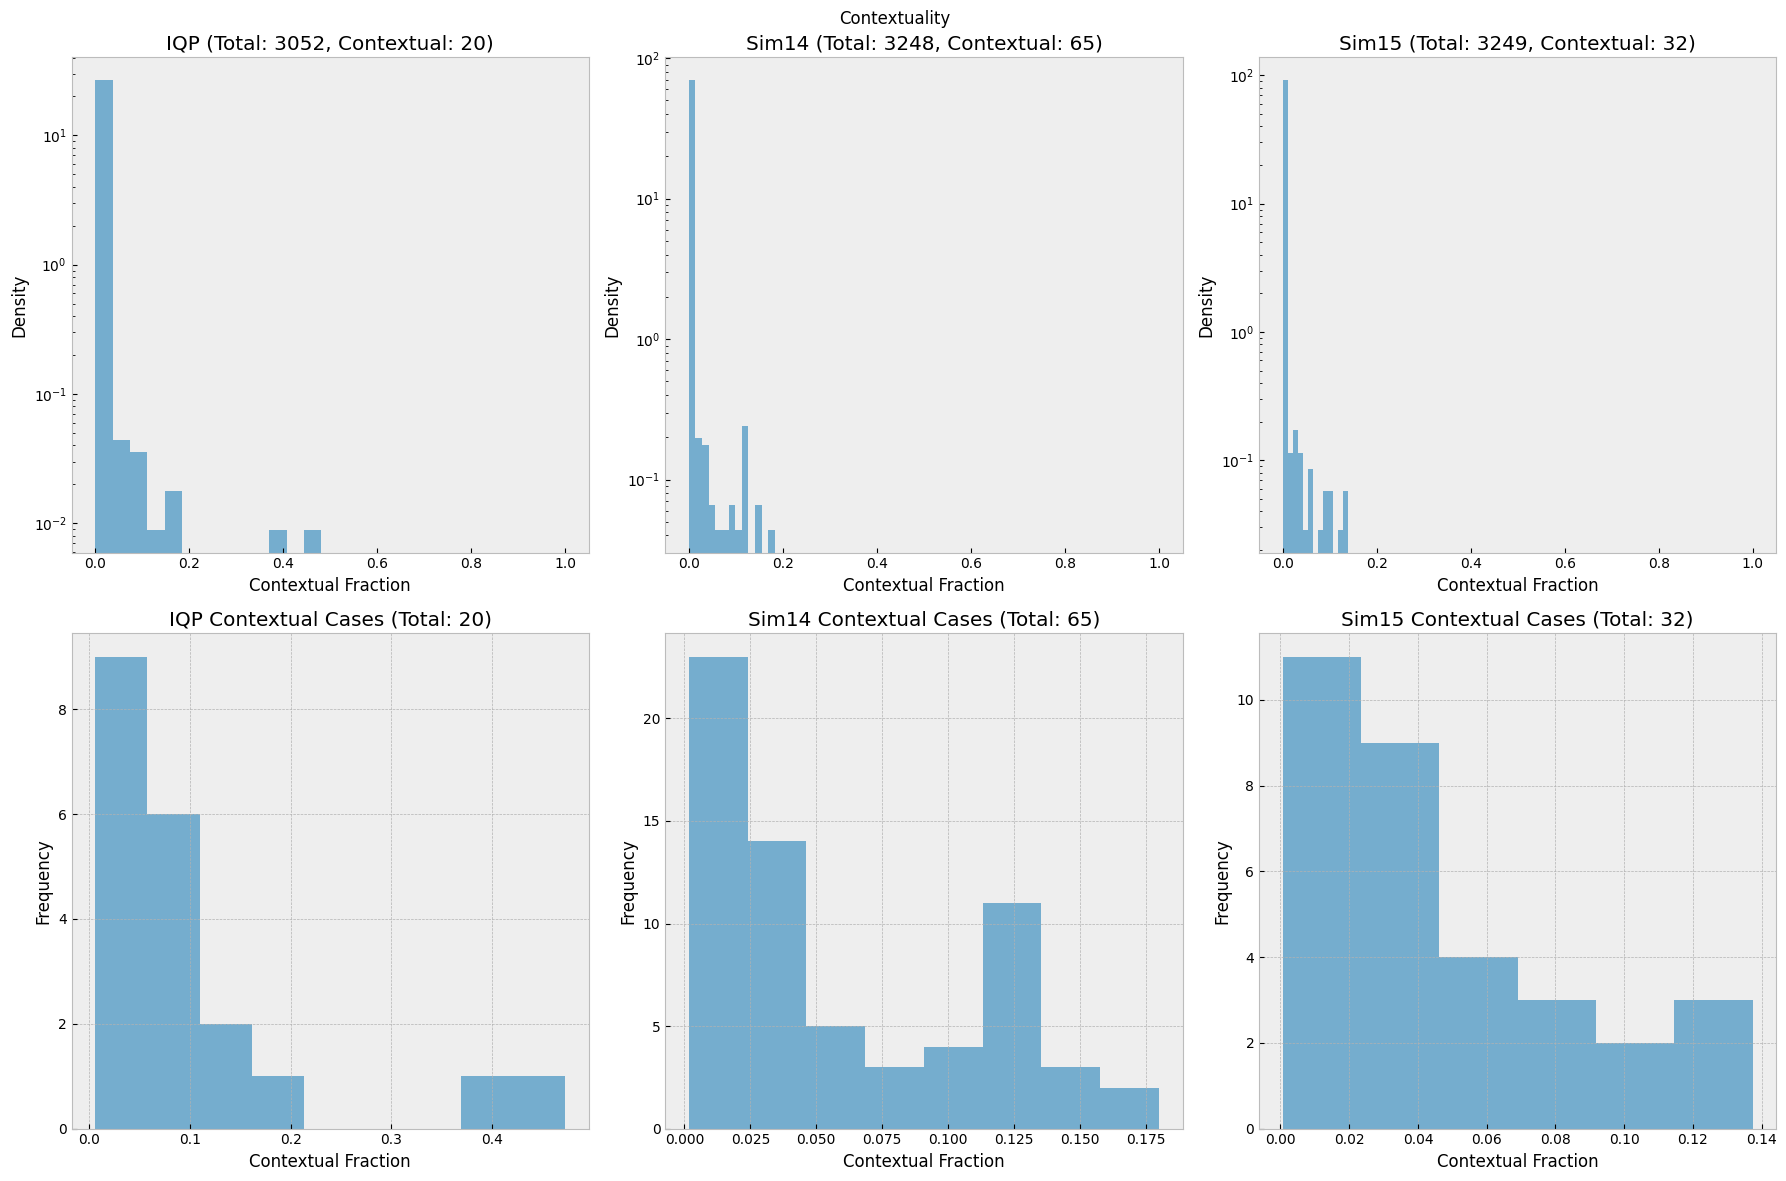

In [5]:
bins = 10
fig = plt.figure(figsize=(18,12))
plt.style.use("bmh")
ax = fig.add_subplot(2,3,1)
ax.grid(False)
plt.hist(iqp.data['CF'], bins='auto', log=True, range=(0,1), density=True, alpha = 0.65)
ax.set_title(f"IQP (Total: {len(iqp.data['CF'])}, Contextual: {len(iqp.data['CF'][iqp.data['CF']>0])})")
ax.set_xlabel('Contextual Fraction')
ax.set_ylabel('Density')
ax = fig.add_subplot(2,3,2)
ax.grid(False)
plt.hist(sim14.data['CF'], bins='auto', log=True, range=(0,1), density=True, alpha = 0.65)
ax.set_title(f"Sim14 (Total: {len(sim14.data['CF'])}, Contextual: {len(sim14.data['CF'][sim14.data['CF']>0])})")
ax.set_xlabel('Contextual Fraction')
ax.set_ylabel('Density')
ax = fig.add_subplot(2,3,3)
ax.grid(False)
plt.hist(sim15.data['CF'], bins='auto', log=True, range=(0,1), density=True, alpha = 0.65)
ax.set_title(f"Sim15 (Total: {len(sim15.data['CF'])}, Contextual: {len(sim15.data['CF'][sim15.data['CF']>0])})")
ax.set_xlabel('Contextual Fraction')
ax.set_ylabel('Density')

ax = fig.add_subplot(2,3,4)
plt.hist(iqp.data['CF'][iqp.data['CF']>0], bins='auto', alpha = 0.65)
ax.set_title(f"IQP Contextual Cases (Total: {len(iqp.data['CF'][iqp.data['CF']>0])})")
ax.set_xlabel('Contextual Fraction')
ax.set_ylabel('Frequency')
ax = fig.add_subplot(2,3,5)
plt.hist(sim14.data['CF'][sim14.data['CF']>0], bins='auto', alpha = 0.65)
ax.set_title(f"Sim14 Contextual Cases (Total: {len(sim14.data['CF'][sim14.data['CF']>0])})")
ax.set_xlabel('Contextual Fraction')
ax.set_ylabel('Frequency')
ax = fig.add_subplot(2,3,6)
plt.hist(sim15.data['CF'][sim15.data['CF']>0], bins='auto', alpha = 0.65)
ax.set_title(f"Sim15 Contextual Cases (Total: {len(sim15.data['CF'][sim15.data['CF']>0])})")
ax.set_xlabel('Contextual Fraction')
ax.set_ylabel('Frequency')
fig.suptitle("Contextuality")
fig.tight_layout()

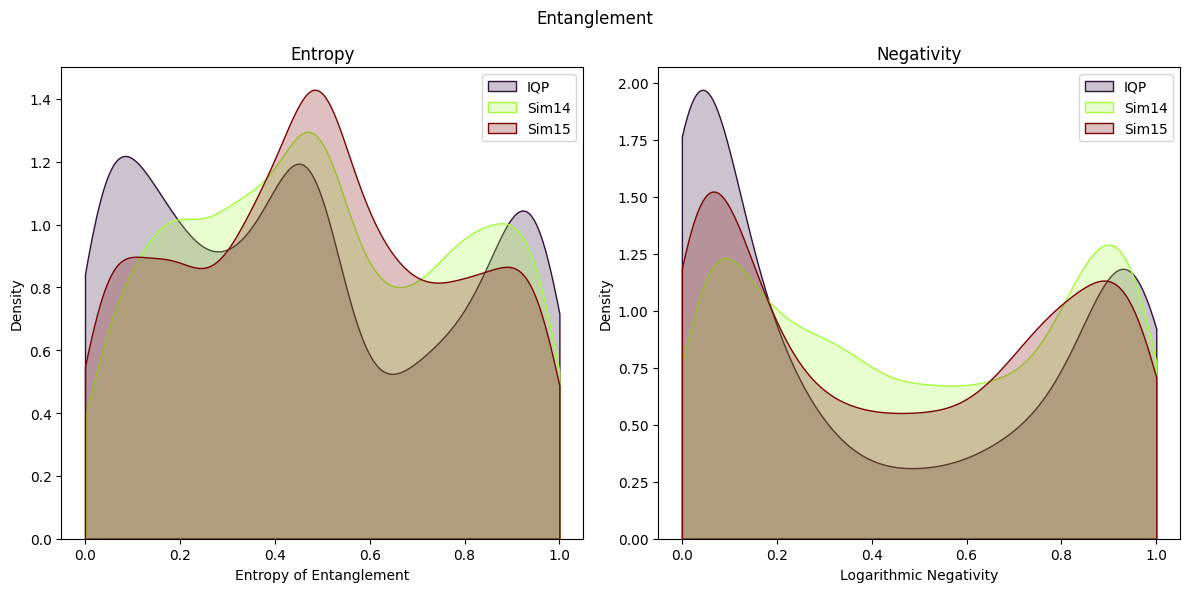

In [8]:
fig = plt.figure(figsize=(12,6))

ax = fig.add_subplot(1,2,1)
plot_dist(ax, [iqp.data['Entropy'], sim14.data['Entropy'], sim15.data['Entropy']], ['IQP', 'Sim14', 'Sim15'], "Entropy")
ax.set_xlabel('Entropy of Entanglement')

ax = fig.add_subplot(1,2,2)
plot_dist(ax, [iqp.data['LogNeg'], sim14.data['LogNeg'], sim15.data['LogNeg']], ['IQP', 'Sim14', 'Sim15'], "Negativity")
ax.set_xlabel('Logarithmic Negativity')

fig.suptitle("Entanglement")
fig.tight_layout()
#fig.savefig("figures/new_figs/cnxt")

In [99]:
print(f"Average EoE:\t\tIQP ({round(np.mean(iqp.data['Entropy']), 2)})", end=' | ')
print(f"Sim14 ({round(np.mean(sim14.data['Entropy']), 2)})", end='  | ')
print(f"Sim15 ({round(np.mean(sim15.data['Entropy']), 2)})")
print(f"No. EoE > 0.8:\t\tIQP ({len(iqp.data['Entropy'][iqp.data['Entropy'] > 0.8])})", end='  | ')
print(f"Sim14 ({len(sim14.data['Entropy'][sim14.data['Entropy'] > 0.8])})", end='  | ')
print(f"Sim15 ({len(sim15.data['Entropy'][sim15.data['Entropy'] > 0.8])})")
print(f"No. EoE < 0.2:\t\tIQP ({len(iqp.data['Entropy'][iqp.data['Entropy'] < 0.2])})", end='  | ')
print(f"Sim14 ({len(sim14.data['Entropy'][sim14.data['Entropy'] < 0.2])})", end='  | ')
print(f"Sim15 ({len(sim15.data['Entropy'][sim15.data['Entropy'] < 0.2])})")
print(f"No. 0.2 < EoE < 0.8:\tIQP ({len(iqp.data['Entropy'][(iqp.data['Entropy'] < 0.8) & (iqp.data['Entropy'] > 0.2)])})", end=' | ')
print(f"Sim14 ({len(sim14.data['Entropy'][(sim14.data['Entropy'] < 0.8) & (sim14.data['Entropy'] > 0.2)])})", end=' | ')
print(f"Sim15 ({len(sim15.data['Entropy'][(sim15.data['Entropy'] < 0.8) & (sim15.data['Entropy'] > 0.2)])})")

Average EoE:		IQP (0.46) | Sim14 (0.5)  | Sim15 (0.49)
No. EoE > 0.8:		IQP (694)  | Sim14 (664)  | Sim15 (582)
No. EoE < 0.2:		IQP (835)  | Sim14 (592)  | Sim15 (637)
No. 0.2 < EoE < 0.8:	IQP (1523) | Sim14 (1992) | Sim15 (2030)


In [103]:
print(f"Average LogNeg:\t\tIQP ({round(np.mean(iqp.data['LogNeg']), 2)})", end=' | ')
print(f"Sim14 ({round(np.mean(sim14.data['LogNeg']), 2)})", end='  | ')
print(f"Sim15 ({round(np.mean(sim15.data['LogNeg']), 2)})")
print(f"No. LogNeg > 0.8:\tIQP ({len(iqp.data['LogNeg'][iqp.data['LogNeg'] > 0.8])})", end='  | ')
print(f"Sim14 ({len(sim14.data['LogNeg'][sim14.data['LogNeg'] > 0.8])})", end='  | ')
print(f"Sim15 ({len(sim15.data['LogNeg'][sim15.data['LogNeg'] > 0.8])})")
print(f"No. LogNeg < 0.2:\tIQP ({len(iqp.data['Entropy'][iqp.data['Entropy'] < 0.2])})", end='  | ')
print(f"Sim14 ({len(sim14.data['LogNeg'][sim14.data['LogNeg'] < 0.2])})", end='  | ')
print(f"Sim15 ({len(sim15.data['LogNeg'][sim15.data['LogNeg'] < 0.2])})")
print(f"No. 0.2 < LogNeg < 0.8: IQP ({len(iqp.data['LogNeg'][(iqp.data['LogNeg'] < 0.8) & (iqp.data['LogNeg'] > 0.2)])})", end='  | ')
print(f"Sim14 ({len(sim14.data['LogNeg'][(sim14.data['LogNeg'] < 0.8) & (sim14.data['LogNeg'] > 0.2)])})", end=' | ')
print(f"Sim15 ({len(sim15.data['LogNeg'][(sim15.data['LogNeg'] < 0.8) & (sim15.data['LogNeg'] > 0.2)])})")

Average LogNeg:		IQP (0.41) | Sim14 (0.5)  | Sim15 (0.46)
No. LogNeg > 0.8:	IQP (861)  | Sim14 (921)  | Sim15 (819)
No. LogNeg < 0.2:	IQP (835)  | Sim14 (867)  | Sim15 (1137)
No. 0.2 < LogNeg < 0.8: IQP (749)  | Sim14 (1460) | Sim15 (1293)


In [78]:
print(np.mean(iqp.data['Entropy'][iqp.data['CF'] > 0])) 
print(np.mean(sim14.data['Entropy'][sim14.data['CF'] > 0]))
print(np.mean(sim15.data['Entropy'][sim15.data['CF'] > 0]))

0.57992262272315
0.6650074655035847
0.6868465716771562


In [10]:
from sklearn import svm
data_r, data_w = get_sim([ow_rref.data.sample(frac=1), ow_wref.data.sample(frac=1)])
total = len(data_r)
data_1 = data_r[:round(total*0.8)]
data_2 = data_w[:round(total*0.8)]
data = np.concatenate([list(data_1['LogNeg'].to_numpy()), 
                       list(data_2['LogNeg'].to_numpy())])
data = [[ele] for ele in data]
data = list(zip(data, [1]*round(total*0.8) + [0]*round(total*0.8)))
random.shuffle(data)
data, labels = zip(*data)
predictor = svm.SVC()
predictor.fit(list(data), list(labels))

SVC()

In [11]:
test1 = data_r['LogNeg'][round(total*0.8):]
test2 = data_w['LogNeg'][round(total*0.8):]
test1 = [[ele] for ele in test1]
test2 = [[ele] for ele in test2]
res1 = predictor.predict(test1)
res2 = predictor.predict(test2)
print("Distinguish right and wrong referents")
print(f"Right referent accuracy: {(sum(res1)/len(res1))*100}")
print(f"Wrong referent accuracy: {(sum(res2)/len(res2))*100}")
print(f"Total accuracy: {(sum(res1) + sum(res2))/(len(res1)+len(res2))*100 }")

Distinguish right and wrong referents
Right referent accuracy: 44.71403812824957
Wrong referent accuracy: 35.875216637781634
Total accuracy: 40.294627383015595
